In [1]:
import json, os, cv2, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps

In [2]:
class ANPR:
    def __init__(self, segmentation_model_path, character_model_path):
        self.seg_model = load_model(segmentation_model_path, custom_objects = {"BinaryIoU_func" : self.BinaryIoU_func})
        self.char_model = load_model(character_model_path)

    def BinaryIoU_func(y_true, y_pred):
        pred = tf.where(y_pred>=0.5, 1, 0)
        pred = tf.cast(pred, dtype = tf.float32)
        true = tf.cast(y_true, dtype = tf.float32)
        n_true = tf.reduce_sum(true)
        n_pred = tf.reduce_sum(pred)
        intersection = tf.reduce_sum(pred * true)
        union = n_true + n_pred - intersection
        iou = intersection/union
        return iou

    def open_image(self, image_path, size = (256,256)):
        image = Image.open(image_path).resize(size).convert('RGB')
        image_array = np.array(image)
        return image_array

    def unet_predict(self, image_path):
        image_array = self.open_image(image_path)
        image_array = image_array[np.newaxis, ...]
        pred = self.seg_model.predict(image_array)[0]
        pred = np.where(pred >= 0.5, 255, 0)[:,:,0]

        return pred.astype(np.uint8)

    def postprocess_segmentation(self, unet_result, image_path):
        src1_mask = cv2.resize(unet_result, (5*256, 5*256), interpolation = cv2.INTER_LANCZOS4)
        src1 = cv2.resize(cv2.imread(image_path), (5*256,5*256))
        src1_mask = cv2.cvtColor(src1_mask,cv2.COLOR_GRAY2BGR)#change mask to a 3 channel image 
        mask_out = cv2.subtract(src1_mask,src1)
        cv2_image = cv2.subtract(src1_mask,mask_out)

        gray = cv2.cvtColor(cv2_image,cv2.COLOR_BGR2GRAY)
        try:
            contours,hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)
            cnt = contours[0]
            x,y,w,h = cv2.boundingRect(cnt)
        except IndexError:
            print(f"Model can't detect plate")

        crop = cv2_image[y:y+h,x:x+w]
        h,w,_ = crop.shape
        scaler = 400//h
        crop = cv2.resize(crop, (300,300))

        return crop

    def seg_prediction(self, image_path):
        result = self.unet_predict(image_path)
        postprocess = self.postprocess_segmentation(unet_result = result,
                                               image_path = image_path)
        
        return postprocess

    def char_predict(self, img):
        mapping = {}
        CHARACTER = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        for idx, c in enumerate(CHARACTER):
            mapping[idx] = c

        image_array = np.array(Image.fromarray(img).resize((75,75)).convert('RGB'))
        image_array = image_array[np.newaxis, ...]
        prediction = self.char_model.predict(image_array)
        idx = np.argmax(prediction)
        return mapping[idx]

    def identify_char(self, crop_img):
        list_char = ''
        image = crop_img.copy()
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
        kernel_erosion = np.ones((3,3), np.uint8)
        kernel_dilation = np.ones((3,3), np.uint8)
        img_erosion = cv2.erode(thresh,kernel_erosion,iterations = 1)
        img_dilation = cv2.dilate(img_erosion, kernel_dilation, iterations=2)
        #find contours
        ctrs, hier = cv2.findContours(img_dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # #sort contours
        sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

        area = list(map(lambda x: cv2.contourArea(x), ctrs))
        threshold_area = np.quantile(area, 0.25)

        for i, ctr in enumerate(ctrs):
            if hier[0,i,3] == -1:
                # Get bounding box
                x, y, w, h = cv2.boundingRect(ctr)

                if (w > h) or (area[i] < 300):
                    continue

                calon_img = image[y:y+h, x:x+w, :]
                class_char = self.char_predict(calon_img)
                cv2.rectangle(image,(x,y),( x + w, y + h ),(0,255,0),2)
                cv2.putText(image, f'{class_char}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,255,0), 1)
                list_char += class_char

        return {'images': image, 'character': list_char}

    def predict_all(self, image_path):
        seg_prediction = self.seg_prediction(image_path)
        OUTPUT = self.identify_char(seg_prediction)

        return OUTPUT

In [5]:
anpr = ANPR('./SegmentationModel/UNET_VGG19/model.h5', './Character Recognition Model/model_vgg16/model.h5')

5290XFJU5163BW


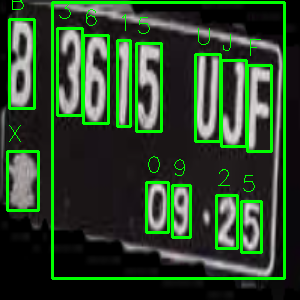

In [11]:
result = anpr.predict_all('./Dataset/images/motor72.jpg')
print(result['character'])
Image.fromarray(result['images'])